In [37]:
##IMPORT ##

import pandas as pd
pd.set_option('display.max_columns', None)
import math 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error

import xgboost as xgb



## Load Data

In [52]:
%reload_kedro
df_champs = catalog.load('df_champs_elysee_days_meteo_bank')

[12/08/22 21:00:06] INFO     Resolved project path as:                                              ]8;id=597405;file:///Users/padoa/opt/anaconda3/lib/python3.9/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=945457;file:///Users/padoa/opt/anaconda3/lib/python3.9/site-packages/kedro/ipython/__init__.py#132\132]8;;\
                             /Users/padoa/PycharmProjects/pythonProject2/BCG_Hackaton/datathon-bcg-                
                             gamma.                                                                                
                             To set a different path, run '%reload_kedro <project_root>'                           

[12/08/22 21:00:07] WARNING  /Users/padoa/opt/anaconda3/lib/python3.9/site-packages/kedro/framework ]8;id=757681;file:///Users/padoa/opt/anaconda3/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=983820;file:///Users/padoa/opt/anaconda3/lib/python3.9/warnings.py#109\109]8;;\
                             /context/context.py:339: UserWarning: Credentials not found in your                   
                             Kedro project config.                                                                 
                             No files found in                                                                     
                             ['/Users/padoa/PycharmProjects/pythonProject2/BCG_Hackaton/datathon-bc                
                             g-gamma/conf/base',                                                                   
                             '/Users/padoa/PycharmProjects/pythonProject2/BCG_Hackaton/datathon-bcg                
                             -gamma/conf/local'] matching the glob pattern(s): ['credentials*',                    
                             'credentials*/**', '**/credentials*']                                                 
                               warn(f"Credentials not found in your Kedro project                                  
                             config.\n{str(exc)}")                                                                 
                                                                                                                   

                    INFO     Kedro project Datathon BCG Gamma                                       ]8;id=920940;file:///Users/padoa/opt/anaconda3/lib/python3.9/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=650757;file:///Users/padoa/opt/anaconda3/lib/python3.9/site-packages/kedro/ipython/__init__.py#101\101]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=226605;file:///Users/padoa/opt/anaconda3/lib/python3.9/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=735577;file:///Users/padoa/opt/anaconda3/lib/python3.9/site-packages/kedro/ipython/__init__.py#102\102]8;;\
                             'pipelines'                                                                           

                    INFO     Loading data from 'df_champs_elysee_days_meteo_bank'               ]8;id=424450;file:///Users/padoa/opt/anaconda3/lib/python3.9/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=260556;file:///Users/padoa/opt/anaconda3/lib/python3.9/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (ParquetDataSet)...                                                                   

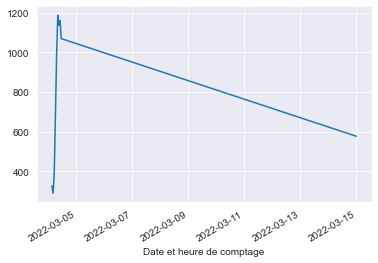

In [53]:
df_plot = df_champs.set_index('Date et heure de comptage')
df_plot[2950:2960]["Débit horaire"].plot()

## Next to do :
<ol>
   <li>Data cleaning test (create differentes pipelines and test on 3 algos)</li>
   <ul>
        <li>Delete Na and test</li>
        <li>Drop values with difference too high</li>
        <li>Drop outliers</li>
   </ul>
   <li>New models</li>
   <li>Pick strongest Models</li>
   <li>Feature Tuning & RFE</li>
   <li>Back testing</li> 
   <li>Export model</li>
   <li>Pipeline cleaning</li>
   <li>Clean notebooks</li>
    <li>Business presentation</li>
</ol>


## Pipelines

In [54]:
##Fenetrage
def series_to_supervised(df, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""

	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df[["Taux d'occupation",'Débit horaire']].shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(2)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df[["Taux d'occupation",'Débit horaire']].shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(2)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(2)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	df = df.merge(agg, left_index=True, right_index=True)
	# drop rows with NaN values
	if dropnan:
		df.dropna(inplace=True)
	return df


In [55]:
##Fenetrage
def series_to_supervised_dif(df, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""

	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df[["Taux d'occupation",'Débit horaire']].shift(i) - df[["Taux d'occupation",'Débit horaire']].shift(i+1))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(2)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df[["Taux d'occupation",'Débit horaire']].shift(-i) - df[["Taux d'occupation",'Débit horaire']].shift(-1-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(2)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(2)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	df = df.merge(agg, left_index=True, right_index=True)
	# drop rows with NaN values
	if dropnan:
		df.dropna(inplace=True)
	return df


In [56]:
def series_to_supervised_dif_2(df, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df[["Taux d'occupation",'Débit horaire']].shift(i) - df[["Taux d'occupation",'Débit horaire']].shift(i+1))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(2)]
    # forecast sequence (t, t+1, ... t+n)
    cols.append(df[["Taux d'occupation",'Débit horaire']])
    names += ['var_r1(t-1)', 'var_r2(t-1)']
    for i in range(0, n_out):
        cols.append(df[["Taux d'occupation",'Débit horaire']].shift(-i) - df[["Taux d'occupation",'Débit horaire']].shift(-1-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(2)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(2)]

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    df = df.merge(agg, left_index=True, right_index=True)
    # drop rows with NaN values
    if dropnan:
        df.dropna(inplace=True)
    return df

In [44]:
def create_pipeline(num_col, min_max_col):
    ##Pipelines Scikit Learn
    ct_scaler = ColumnTransformer(
        transformers=[
            ("scaler", StandardScaler(), num_col),
            ("scaler_minmax", MinMaxScaler(), min_max_col),
        ]
    )

    pipeline_master = Pipeline([
        ("preprocessor", ct_scaler),
        ])
    
    return pipeline_master

In [45]:
def max_n_errors (real_taux, real_debit, predicted_taux,predicted_debit):
    RMSE_taux = (pd.DataFrame(real_taux - predicted_taux)**2)**0.5
    RMSE_debit = (pd.DataFrame(real_debit - predicted_debit)**2)**0.5
    x_taux = np.argsort(RMSE_taux)[::-1][:20]
    x_debit = np.argsort(RMSE_debit)[::-1][:20]
    return (x_taux, x_debit)

## Prediction à t using past values and Hexogenous data

In [46]:
index_weekend = df_champs.loc[(df_champs.wday_Saturday==1) | (df_champs.wday_Sunday==1)].index
df_champs_without_weekend = df_champs.drop(index_weekend)

In [47]:
def normalize(data):
    return (data - data.mean())/data.std()

def unormalize(data, previous):
    return (data*previous.std()) + previous.mean()

(8148, 186)
(8148,)
3.5078997661519713 6.704112677732556 63.169417144357595 280.37239393851473


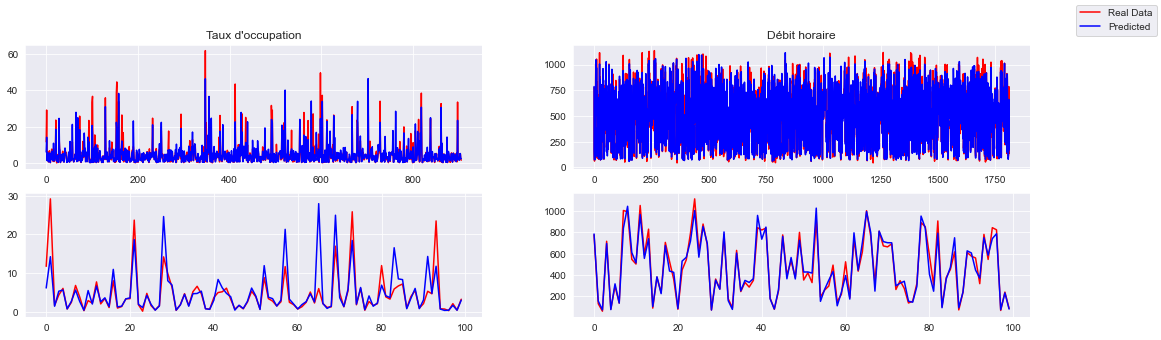

In [48]:
df_preprocessed_champs = series_to_supervised(df_champs, 72, 1)
df_preprocessed_champs = df_preprocessed_champs.drop(columns=["Taux d'occupation","Débit horaire"]) 
y_taux_t = df_preprocessed_champs['var1(t)']

y_debit_t = df_preprocessed_champs['var2(t)']

names_taux_drop = [('var2(t-%d)' % (i)) for i in range(1,49)]
names_debit_drop = [('var1(t-%d)' % (j)) for j in range(1,49)]
X_taux = df_preprocessed_champs.drop(columns=['var1(t)','var2(t)'] + names_taux_drop)
X_debit = df_preprocessed_champs.drop(columns=['var1(t)','var2(t)']+ names_debit_drop)
X_taux = X_taux.drop(columns=['Libelle','Date et heure de comptage','date'])
X_debit = X_debit.drop(columns=['Libelle','Date et heure de comptage','date'])

## Data split 
X_train_taux, X_test_taux,y_taux_train, y_taux_test = train_test_split(X_taux,y_taux_t, test_size=0.1)
X_train_debit, X_test_debit,y_debit_train, y_debit_test = train_test_split(X_debit,y_debit_t, test_size=0.2)

y_taux_train_norm = normalize(y_taux_train)

y_debit_train_norm = normalize(y_debit_train)

## Features type declaration
min_max_columns = ['vacances','est_ferie','year_2021','year_2022','hour_0','hour_1','hour_2','hour_3','hour_4','hour_5','hour_6','hour_7','hour_8','hour_9','hour_10','hour_11','hour_12','hour_13','hour_14','hour_15','hour_16','hour_17','hour_18','hour_19','hour_20','hour_21','hour_22','hour_23','day_1','day_2','day_3','day_4','day_5','day_6','day_7','day_8','day_9','day_10','day_11','day_12','day_13','day_14','day_15','day_16','day_17','day_18','day_19','day_20','day_21','day_22','day_23','day_24','day_25','day_26','day_27','day_28','day_29','day_30','day_31','wday_Monday','wday_Tuesday','wday_Wednesday','wday_Thursday','wday_Friday','wday_Saturday','wday_Sunday','month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12']
numerical_col_taux = [feature for feature in list(X_taux) if feature not in min_max_columns]
numerical_col_debit = [feature for feature in list(X_debit) if feature not in min_max_columns]

## Normalisation : 
pipeline_taux = create_pipeline(numerical_col_taux,min_max_columns)
X_train_taux_preprocessed = pipeline_taux.fit_transform(X_train_taux)
X_test_taux_preprocessed = pipeline_taux.transform(X_test_taux)


pipeline_debit = create_pipeline(numerical_col_debit,min_max_columns)
X_train_debit_preprocessed = pipeline_debit.fit_transform(X_train_debit)
X_test_debit_preprocessed = pipeline_debit.transform(X_test_debit)

##Modelisation : 

## Prediction of taux at t :
print(X_train_taux_preprocessed.shape)
print(y_taux_train_norm.shape)
model_taux_t = xgb.XGBRegressor()
model_taux_t = model_taux_t.fit(X_train_taux_preprocessed,y_taux_train_norm)

## Prediction of débit at t : 
model_debit_t = xgb.XGBRegressor()
model_debit_t = model_debit_t.fit(X_train_debit_preprocessed, y_debit_train_norm)


#Testing data 
y_pred_taux_t = model_taux_t.predict(X_test_taux_preprocessed)
y_pred_taux_t = unormalize(y_pred_taux_t, y_taux_train)
MSE_taux = mean_squared_error(y_taux_test, y_pred_taux_t)

y_pred_debit_t = model_debit_t.predict(X_test_debit_preprocessed)
y_pred_debit_t = unormalize(y_pred_debit_t, y_debit_train)
MSE_debit = mean_squared_error(y_debit_test,y_pred_debit_t)

print(MSE_taux**0.5,y_taux_test.std(),MSE_debit**0.5,y_debit_test.std())

#Plot 
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(18, 5))
n_taux = len(y_taux_test)
t_taux = np.arange(n_taux)
# plt.figure("Taux d'occupation")
ax[0,0].plot(t_taux,y_taux_test, 'r')
ax[0,0].plot(t_taux,y_pred_taux_t, 'b')
ax[0,0].title.set_text("Taux d'occupation")
n_debit= len(y_debit_test)
t_debit = np.arange(n_debit)
# plt.figure("Débit horaire")
ax[0,1].plot(t_debit,y_debit_test, 'r')
ax[0,1].plot(t_debit,y_pred_debit_t, 'b')
ax[0,1].title.set_text("Débit horaire")

t_zoom = np.arange(100)
ax[1,0].plot(t_zoom,y_taux_test[:100], 'r')
ax[1,0].plot(t_zoom,y_pred_taux_t[:100], 'b')

ax[1,1].plot(t_zoom,y_debit_test[:100], 'r')
ax[1,1].plot(t_zoom,y_pred_debit_t[:100], 'b')
fig.legend(['Real Data','Predicted'])
plt.show()

Results :<br>
<ul>
    <li> *Normalize 48 data :* 6.543125921767675 114.55510634593789 </li>
    <li> *Normalize 24 data :* 6.610243944186594 113.86584685609334 </li>
    <li> *Normalize 56 data :* 6.696657063864071 113.82549457847892 </li>
    <li> *Normalize 48v& filled data :* 5.559121953074495 116.54445126329065 </li>
</ul> 


## Prediction on 1 values with K past values without hexogenous data

[12/08/22 20:58:42] INFO     Loading data from 'champs_elysee_with_days_na_filled'              ]8;id=977362;file:///Users/padoa/opt/anaconda3/lib/python3.9/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=702595;file:///Users/padoa/opt/anaconda3/lib/python3.9/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (ParquetDataSet)...                                                                   

                    WARNING  /Users/padoa/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py ]8;id=867966;file:///Users/padoa/opt/anaconda3/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=520467;file:///Users/padoa/opt/anaconda3/lib/python3.9/warnings.py#109\109]8;;\
                             :250: FutureWarning: pandas.Int64Index is deprecated and will be                      
                             removed from pandas in a future version. Use pandas.Index with the                    
                             appropriate dtype instead.                                                            
                               elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):                      
                                                                                                                   

4.002834499165979 82.24360459256513


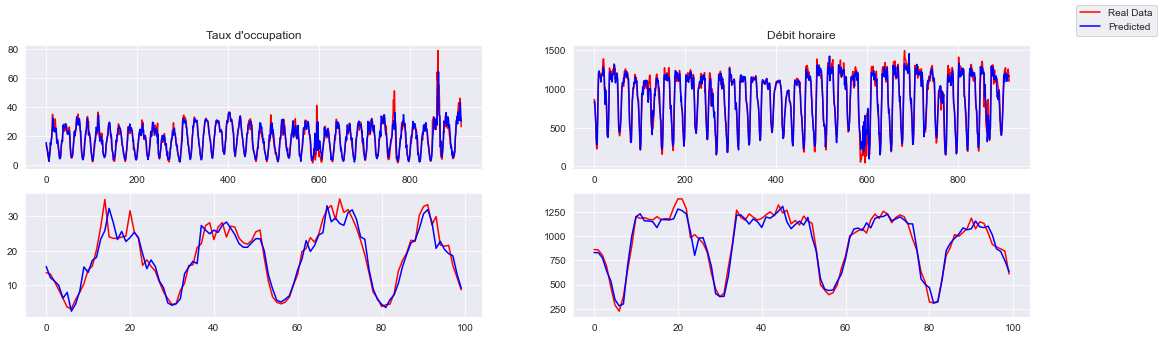

In [49]:
df_time_only = catalog.load('champs_elysee_with_days_na_filled')
df_time_only = df_time_only.drop(columns=['Libelle','Date et heure de comptage','date','vacances'])
df_time_only = pd.get_dummies(df_time_only, columns=['year'], prefix='year')
df_time_only = pd.get_dummies(df_time_only, columns=['hour'], prefix='hour')
df_time_only = pd.get_dummies(df_time_only, columns=['day'], prefix='day')
df_time_only = pd.get_dummies(df_time_only, columns=['day_of_week'], prefix='wday')
df_time_only = pd.get_dummies(df_time_only, columns=['month'], prefix='month')


df_time_only_preprocessd = series_to_supervised(df_time_only, 48, 1)
df_time_only_preprocessd = df_time_only_preprocessd.drop(columns=["Taux d'occupation","Débit horaire"]) 
y_taux_t_time_only = df_time_only_preprocessd['var1(t)']
y_debit_t_time_only = df_time_only_preprocessd['var2(t)']
X_time_only = df_time_only_preprocessd.drop(columns=['var1(t)','var2(t)'])

##Split
offset = int(X_time_only.shape[0] * 0.9)
X_train_time_only, y_taux_train_time_only, y_debit_train_time_only = X_time_only[:offset], y_taux_t_time_only[:offset], y_debit_t_time_only[:offset]
X_test_time_only, y_taux_test_time_only, y_debit_test_time_only = X_time_only[offset:], y_taux_t_time_only[offset:], y_debit_t_time_only[offset:]


#Models
model_taux_time_only = xgb.XGBRegressor()
model_taux_time_only = model_taux_time_only.fit(X_train_time_only,y_taux_train_time_only) 

model_debit_time_only = xgb.XGBRegressor()
model_debit_time_only = model_debit_time_only.fit(X_train_time_only,y_debit_train_time_only) 


#Testing
y_pred_taux_time_only_t = model_taux_time_only.predict(X_test_time_only)
RMSE_taux_time_only = mean_squared_error(y_taux_test_time_only, y_pred_taux_time_only_t)


y_pred_debit_time_only_t = model_debit_time_only.predict(X_test_time_only)
RMSE_debit_time_only = mean_squared_error(y_debit_test_time_only, y_pred_debit_time_only_t)

print(RMSE_taux_time_only**0.5,RMSE_debit_time_only**0.5)

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(18, 5))
n_taux_time_only = len(y_taux_test_time_only)
t_taux_time_only = np.arange(n_taux_time_only)
# plt.figure("Taux d'occupation")
ax[0,0].plot(t_taux_time_only,y_taux_test_time_only, 'r')
ax[0,0].plot(t_taux_time_only,y_pred_taux_time_only_t, 'b')
ax[0,0].title.set_text("Taux d'occupation")

n_debit_time_only= len(y_pred_debit_time_only_t)
t_debit_time_only = np.arange(n_debit_time_only)
# plt.figure("Débit horaire")
ax[0,1].plot(t_debit_time_only,y_debit_test_time_only, 'r')
ax[0,1].plot(t_debit_time_only,y_pred_debit_time_only_t, 'b')
ax[0,1].title.set_text("Débit horaire")

t_zoom = np.arange(100)
ax[1,0].plot(t_zoom,y_taux_test_time_only[:100], 'r')
ax[1,0].plot(t_zoom,y_pred_taux_time_only_t[:100], 'b')

ax[1,1].plot(t_zoom,y_debit_test_time_only[:100], 'r')
ax[1,1].plot(t_zoom,y_pred_debit_time_only_t[:100], 'b')
fig.legend(['Real Data','Predicted'])
plt.show()


## Prediction on N value base K past values and hexogenous data

In [50]:
def normalize_n(data):
    return (data - data.mean().mean())/data.std().mean()

def unormalize_n(data, previous):
    return (data*previous.std().mean()) + previous.mean().mean()

In [60]:
## To reload on Dej because error
df_champs.dropna(inplace=True)
df_preprocessed_champs_n = series_to_supervised(df_champs, 72, 24)
df_preprocessed_champs_n = df_preprocessed_champs_n.drop(columns=["Taux d'occupation","Débit horaire"])
names_taux = ['var1(t)']
names_taux += [('var%d(t+%d)' % (1, i)) for i in range(1,24)]
y_taux_n =  df_preprocessed_champs_n[names_taux]
names_debit = ['var2(t)']
names_debit += [('var%d(t+%d)' % (2, i)) for i in range(1,24)]
y_debit_n = df_preprocessed_champs_n[names_debit]
X_past = df_preprocessed_champs_n.drop(columns=names_debit+names_taux)
X_past = X_past.drop(columns=['Libelle','Date et heure de comptage','date'])

## Data split
# offset = int(X.shape[0] * 0.7)
# X_train_n, y_taux_train_n, y_debit_train_n = X[:offset], y_taux_n[:offset], y_debit_n[:offset]
# X_test_n, y_taux_test_n, y_debit_test_n = X[offset:], y_taux_n[offset:], y_debit_n[offset:]
X_train_taux_n , X_test_taux_n ,y_taux_train_n , y_taux_test_n = train_test_split(X_past,y_taux_n, test_size=0.2, random_state=1)
X_train_debit_n, X_test_debit_n,y_debit_train_n, y_debit_test_n = train_test_split(X_past,y_debit_n, test_size=0.2, random_state=1)

y_taux_train_n_norm = normalize_n(y_taux_train_n)
y_debit_train_n_norm = normalize_n(y_debit_train_n)

## Features type declaration
min_max_columns_n = ['vacances','est_ferie','year_2021','year_2022','hour_0','hour_1','hour_2','hour_3','hour_4','hour_5','hour_6','hour_7','hour_8','hour_9','hour_10','hour_11','hour_12','hour_13','hour_14','hour_15','hour_16','hour_17','hour_18','hour_19','hour_20','hour_21','hour_22','hour_23','day_1','day_2','day_3','day_4','day_5','day_6','day_7','day_8','day_9','day_10','day_11','day_12','day_13','day_14','day_15','day_16','day_17','day_18','day_19','day_20','day_21','day_22','day_23','day_24','day_25','day_26','day_27','day_28','day_29','day_30','day_31','wday_Monday','wday_Tuesday','wday_Wednesday','wday_Thursday','wday_Friday','wday_Saturday','wday_Sunday','month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12']
numerical_col_n = [feature for feature in list(X_past) if feature not in min_max_columns_n]

#Normalization
pipeline_n = create_pipeline(numerical_col_n,min_max_columns_n)
X_train_taux_n_preprocessed = pipeline_n.fit_transform(X_train_taux_n)
X_test_taux_n_preprocessed = pipeline_n.transform(X_test_taux_n)
X_train_debit_n_preprocessed = pipeline_n.fit_transform(X_train_debit_n)
X_test_debit_n_preprocessed = pipeline_n.transform(X_test_debit_n)

#Models

## Prediction of taux at t :
print('Launch Model')
print(X_train_taux_n_preprocessed.shape)
print(y_taux_train_n_norm.shape)
model_taux_n = xgb.XGBRegressor()
model_taux_n = model_taux_n.fit(X_train_taux_n_preprocessed,y_taux_train_n_norm)
print('ok')
## Prediction of débit at t :
model_debit_n = xgb.XGBRegressor()
model_debit_n = model_debit_n.fit(X_train_debit_n_preprocessed, y_debit_train_n_norm)
print('ok')


y_pred_taux_n = model_taux_n.predict(X_test_taux_n_preprocessed)
y_pred_taux_n = unormalize_n(y_pred_taux_n, y_taux_train_n)
MSE_taux_n = mean_squared_error(y_taux_test_n, y_pred_taux_n)


y_pred_debit_n = model_debit_n.predict(X_test_debit_n_preprocessed)
y_pred_debit_n = unormalize_n(y_pred_debit_n, y_debit_train_n)
MSE_debit_n = mean_squared_error(y_debit_test_n, y_pred_debit_n)

print(MSE_taux_n*0.5,MSE_debit_n*0.5)

fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(18, 5))
n_taux_n = len(y_taux_test_n)
t_taux_n = np.arange(n_taux_n)
# plt.figure("Taux d'occupation")
ax[0,0].plot(t_taux_n,y_taux_test_n, 'r')
ax[0,0].plot(t_taux_n,y_pred_taux_n, 'b')
ax[0,0].title.set_text("Taux d'occupation")


n_debit_n= len(y_debit_test_n)
t_debit_n = np.arange(n_debit_n)
# plt.figure("Débit horaire")
ax[0,1].plot(t_debit_n,y_debit_test_n, 'r')
ax[0,1].plot(t_debit_n,y_pred_debit_n, 'b')
ax[0,1].title.set_text("Débit horaire")

t_zoom = np.arange(len(y_taux_test_n.iloc[0, :]))
ax[1,0].plot(t_zoom,y_taux_test_n.iloc[0, :], 'r')
ax[1,0].plot(t_zoom,y_pred_taux_n[0], 'b')

ax[1,1].plot(t_zoom,y_debit_test_n.iloc[0, :], 'r')
ax[1,1].plot(t_zoom,y_pred_debit_n[0], 'b')

ax[1,1].legend(['real','pred'])
# fig.legend(['Real Data','Predicted'])
plt.show()

Launch Model
(7215, 234)
(7215, 24)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /var/folders/59/507pgvns18j0wyn5ctymnl_c0000gn/T/ipykernel_47909/2503949863.py:42 in <cell line: │
│ 42>                                                                                              │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ '/var/folders/59/507pgvns18j0wyn5ctymnl_c0000gn/T/ipykernel_47909/2503949863.py'                 │
│                                                                                                  │
│ /Users/padoa/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:506 in inner_f            │
│                                                                                                  │
│    503 │   │   │   )                                                                             │
│    504 │   │   for k, arg in zip(sig.parameters, args):                                          │
│    505 │   │   │   kwargs[k] = arg                                                               │
│ ❱  506 │   │   return f(**kwargs)                                                                │
│    507 │                                                                                         │
│    508 │   return inner_f                                                                        │
│    509                                                                                           │
│                                                                                                  │
│ /Users/padoa/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:761 in fit             │
│                                                                                                  │
│    758 │   │                                                                                     │
│    759 │   │   """                                                                               │
│    760 │   │   evals_result: TrainingCallback.EvalsLog = {}                                      │
│ ❱  761 │   │   train_dmatrix, evals = _wrap_evaluation_matrices(                                 │
│    762 │   │   │   missing=self.missing,                                                         │
│    763 │   │   │   X=X,                                                                          │
│    764 │   │   │   y=y,                                                                          │
│                                                                                                  │
│ /Users/padoa/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:286 in                 │
│ _wrap_evaluation_matrices                                                                        │
│                                                                                                  │
│    283 │   """Convert array_like evaluation matrices into DMatrix.  Perform validation on the w  │
│    284 │                                                                                         │
│    285 │   """                                                                                   │
│ ❱  286 │   train_dmatrix = create_dmatrix(                                                       │
│    287 │   │   data=X,                                                                           │
│    288 │   │   label=label_transform(y),                                                         │
│    289 │   │   group=group,                                                                      │
│                                                                                                  │
│ /Users/padoa/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:775 in <lambda>        │
│                                                            

8 and 156 RMSE last launch 

In [16]:
y_taux_test_n.std().mean()

14.900209528995065

## Prediction a (T-1-T) diff on K previous values and Hexogenous data

6.698069892567264 7.009866953715496 126.56594083944223 158.8101627886705


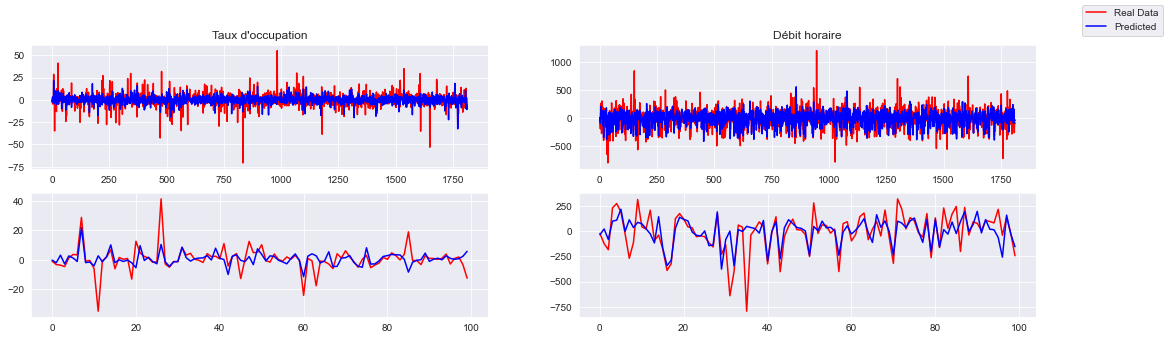

In [17]:
rollback = 48
df_preprocessed_champs_dif = series_to_supervised_dif(df_champs, rollback, 1)
df_preprocessed_champs_dif = df_preprocessed_champs_dif.drop(columns=["Taux d'occupation","Débit horaire",'Libelle','Date et heure de comptage','date']) 
y_taux_dif = df_preprocessed_champs_dif['var1(t)']
y_debit_dif = df_preprocessed_champs_dif['var2(t)']
names_taux_drop = [('var2(t-%d)' % (i)) for i in range(1,rollback + 1)]
names_debit_drop = [('var1(t-%d)' % (j)) for j in range(1,rollback + 1)]
X_dif_taux = df_preprocessed_champs_dif.drop(columns=['var1(t)','var2(t)'] + names_taux_drop)
X_dif_debit = df_preprocessed_champs_dif.drop(columns=['var1(t)','var2(t)'] + names_debit_drop)
# X_rebuild = X_dif[['var_r1(t-1)','var_r2(t-1)']]
# X_dif = X_dif.drop(columns=['var_r1(t-1)','var_r2(t-1)'])
## Data split 

# X_train_dif, y_taux_train_dif, y_debit_train_dif = X_dif[:offset], y_taux_dif[:offset], y_debit_dif[:offset]
# X_test_dif, y_taux_test_dif, y_debit_test_dif = X_dif[offset:], y_taux_dif[offset:], y_debit_dif[offset:]
X_train_taux_dif , X_test_taux_dif ,y_taux_train_dif , y_taux_test_dif = train_test_split(X_dif_taux,y_taux_dif, test_size=0.2)
X_train_debit_dif, X_test_debit_dif,y_debit_train_dif, y_debit_test_dif = train_test_split(X_dif_debit,y_debit_dif, test_size=0.2)

## Features type declaration
min_max_columns_dif = ['vacances','est_ferie','year_2021','year_2022','hour_0','hour_1','hour_2','hour_3','hour_4','hour_5','hour_6','hour_7','hour_8','hour_9','hour_10','hour_11','hour_12','hour_13','hour_14','hour_15','hour_16','hour_17','hour_18','hour_19','hour_20','hour_21','hour_22','hour_23','day_1','day_2','day_3','day_4','day_5','day_6','day_7','day_8','day_9','day_10','day_11','day_12','day_13','day_14','day_15','day_16','day_17','day_18','day_19','day_20','day_21','day_22','day_23','day_24','day_25','day_26','day_27','day_28','day_29','day_30','day_31','wday_Monday','wday_Tuesday','wday_Wednesday','wday_Thursday','wday_Friday','wday_Saturday','wday_Sunday','month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12']
numerical_col_dif_taux = [feature for feature in list(X_dif_taux) if feature not in min_max_columns_dif]
numerical_col_dif_debit = [feature for feature in list(X_dif_debit) if feature not in min_max_columns_dif]
## Normalisation : 
pipeline_dif_taux = create_pipeline(numerical_col_dif_taux,min_max_columns_dif)
pipeline_dif_debit = create_pipeline(numerical_col_dif_debit,min_max_columns_dif)
X_taux_train_preprocessed_dif = pipeline_dif_taux.fit_transform(X_train_taux_dif)
X_taux_test_preprocessed_dif = pipeline_dif_taux.transform(X_test_taux_dif)

X_debit_train_preprocessed_dif = pipeline_dif_debit.fit_transform(X_train_debit_dif)
X_debit_test_preprocessed_dif = pipeline_dif_debit.transform(X_test_debit_dif)



y_taux_train_dif_norm = normalize(y_taux_train_dif)
y_debit_train_dif_norm = normalize(y_debit_train_dif)
##Modelisation : 

## Prediction of taux at t : 
model_taux_dif = xgb.XGBRegressor()
model_taux_dif = model_taux_dif.fit(X_taux_train_preprocessed_dif,y_taux_train_dif_norm)

## Prediction of débit at t : 
model_debit_dif = xgb.XGBRegressor()
model_debit_dif = model_debit_dif.fit(X_debit_train_preprocessed_dif, y_debit_train_dif_norm)


#Testing data 
y_pred_taux_dif = model_taux_dif.predict(X_taux_test_preprocessed_dif)
y_pred_taux_dif = unormalize(y_pred_taux_dif,y_taux_train_dif)
MSE_taux_dif = mean_squared_error(y_taux_test_dif, y_pred_taux_dif)

y_pred_debit_dif = model_debit_dif.predict(X_debit_test_preprocessed_dif)
y_pred_debit_dif = unormalize(y_pred_debit_dif,y_debit_train_dif)
MSE_debit_dif = mean_squared_error(y_debit_test_dif, y_pred_debit_dif)

print(MSE_taux_dif**0.5, y_taux_test_dif.std(),MSE_debit_dif**0.5, y_debit_test_dif.std())

#Plot 
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(18, 5))
n_taux_dif = len(y_taux_test_dif)
t_taux_dif = np.arange(n_taux_dif)
# plt.figure("Taux d'occupation")
ax[0,0].plot(t_taux_dif,y_taux_test_dif, 'r')
ax[0,0].plot(t_taux_dif,y_pred_taux_dif, 'b')
ax[0,0].title.set_text("Taux d'occupation")
n_debit_dif= len(y_debit_test_dif)
t_debit_dif = np.arange(n_debit_dif)
# plt.figure("Débit horaire")
ax[0,1].plot(t_debit_dif,y_debit_test_dif, 'r')
ax[0,1].plot(t_debit_dif,y_pred_debit_dif, 'b')
ax[0,1].title.set_text("Débit horaire")

t_zoom = np.arange(100)
ax[1,0].plot(t_zoom,y_taux_test_dif[:100], 'r')
ax[1,0].plot(t_zoom,y_pred_taux_dif[:100], 'b')

ax[1,1].plot(t_zoom,y_debit_test_dif[:100], 'r')
ax[1,1].plot(t_zoom,y_pred_debit_dif[:100], 'b')
fig.legend(['Real Data','Predicted'])
plt.show()

3.3252654793489147 3.901201399649164 80.39613148315604 136.3575499071475


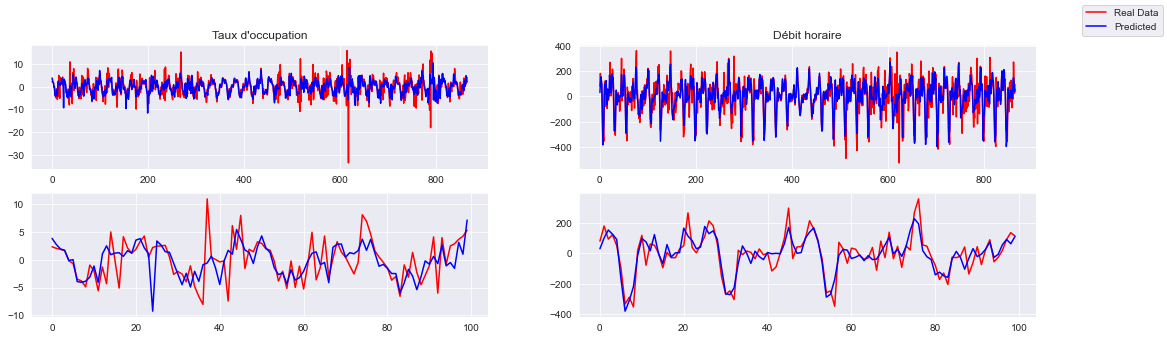

In [18]:
## With old split

df_preprocessed_champs_dif = series_to_supervised_dif(df_champs, 24, 1)
df_preprocessed_champs_dif = df_preprocessed_champs_dif.drop(columns=["Taux d'occupation","Débit horaire"]) 
y_taux_dif = df_preprocessed_champs_dif['var1(t)']
y_debit_dif = df_preprocessed_champs_dif['var2(t)']
X_dif = df_preprocessed_champs_dif.drop(columns=['var1(t)','var2(t)'])
X_dif = X_dif.drop(columns=['Libelle','Date et heure de comptage','date'])
# X_rebuild = X_dif[['var_r1(t-1)','var_r2(t-1)']]
# X_dif = X_dif.drop(columns=['var_r1(t-1)','var_r2(t-1)'])
## Data split 

X_train_dif, y_taux_train_dif, y_debit_train_dif = X_dif[:offset], y_taux_dif[:offset], y_debit_dif[:offset]
X_test_dif, y_taux_test_dif, y_debit_test_dif = X_dif[offset:], y_taux_dif[offset:], y_debit_dif[offset:]
# X_train_taux_dif , X_test_taux_dif ,y_taux_train_dif , y_taux_test_dif = train_test_split(X_dif,y_taux_dif, test_size=0.2, random_state=1)
# X_train_debit_dif, X_test_debit_dif,y_debit_train_dif, y_debit_test_dif = train_test_split(X_dif,y_debit_dif, test_size=0.2, random_state=1)

## Features type declaration
min_max_columns_dif = ['vacances','est_ferie','year_2021','year_2022','hour_0','hour_1','hour_2','hour_3','hour_4','hour_5','hour_6','hour_7','hour_8','hour_9','hour_10','hour_11','hour_12','hour_13','hour_14','hour_15','hour_16','hour_17','hour_18','hour_19','hour_20','hour_21','hour_22','hour_23','day_1','day_2','day_3','day_4','day_5','day_6','day_7','day_8','day_9','day_10','day_11','day_12','day_13','day_14','day_15','day_16','day_17','day_18','day_19','day_20','day_21','day_22','day_23','day_24','day_25','day_26','day_27','day_28','day_29','day_30','day_31','wday_Monday','wday_Tuesday','wday_Wednesday','wday_Thursday','wday_Friday','wday_Saturday','wday_Sunday','month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12']
numerical_col_dif = [feature for feature in list(X_dif) if feature not in min_max_columns_dif]
## Normalisation : 
pipeline_dif = create_pipeline(numerical_col_dif,min_max_columns_dif)
X_train_preprocessed_dif = pipeline_dif.fit_transform(X_train_dif)
X_test_preprocessed_dif = pipeline_dif.transform(X_test_dif)
# X_taux_train_preprocessed_dif = pipeline_dif.fit_transform(X_train_taux_dif)
# X_taux_test_preprocessed_dif = pipeline_dif.transform(X_test_taux_dif)

# X_debit_train_preprocessed_dif = pipeline_dif.fit_transform(X_train_debit_dif)
# X_debit_test_preprocessed_dif = pipeline_dif.transform(X_test_debit_dif)



y_taux_train_dif_norm = normalize(y_taux_train_dif)
y_debit_train_dif_norm = normalize(y_debit_train_dif)
##Modelisation : 

## Prediction of taux at t : 
model_taux_dif = xgb.XGBRegressor()
model_taux_dif = model_taux_dif.fit(X_train_preprocessed_dif,y_taux_train_dif_norm)

## Prediction of débit at t : 
model_debit_dif = xgb.XGBRegressor()
model_debit_dif = model_debit_dif.fit(X_train_preprocessed_dif, y_debit_train_dif_norm)


#Testing data 
y_pred_taux_dif = model_taux_dif.predict(X_test_preprocessed_dif)
y_pred_taux_dif = unormalize(y_pred_taux_dif,y_taux_train_dif)
MSE_taux_dif = mean_squared_error(y_taux_test_dif, y_pred_taux_dif)

y_pred_debit_dif = model_debit_dif.predict(X_test_preprocessed_dif)
y_pred_debit_dif = unormalize(y_pred_debit_dif,y_debit_train_dif)
MSE_debit_dif = mean_squared_error(y_debit_test_dif, y_pred_debit_dif)

print(MSE_taux_dif**0.5, y_taux_test_dif.std(),MSE_debit_dif**0.5, y_debit_test_dif.std())

#Plot 
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(18, 5))
n_taux_dif = len(y_taux_test_dif)
t_taux_dif = np.arange(n_taux_dif)
# plt.figure("Taux d'occupation")
ax[0,0].plot(t_taux_dif,y_taux_test_dif, 'r')
ax[0,0].plot(t_taux_dif,y_pred_taux_dif, 'b')
ax[0,0].title.set_text("Taux d'occupation")
n_debit_dif= len(y_debit_test_dif)
t_debit_dif = np.arange(n_debit_dif)
# plt.figure("Débit horaire")
ax[0,1].plot(t_debit_dif,y_debit_test_dif, 'r')
ax[0,1].plot(t_debit_dif,y_pred_debit_dif, 'b')
ax[0,1].title.set_text("Débit horaire")

t_zoom = np.arange(100)
ax[1,0].plot(t_zoom,y_taux_test_dif[:100], 'r')
ax[1,0].plot(t_zoom,y_pred_taux_dif[:100], 'b')

ax[1,1].plot(t_zoom,y_debit_test_dif[:100], 'r')
ax[1,1].plot(t_zoom,y_pred_debit_dif[:100], 'b')
fig.legend(['Real Data','Predicted'])
plt.show()

In [19]:
## Rebuild 
predicted_taux_test = (X_rebuild[offset:]['var_r1(t-1)'] - y_pred_taux_dif)[:-1]
predicted_debit_test = (X_rebuild[offset:]['var_r2(t-1)'] - y_pred_debit_dif)[:-1]
real_data_taux = X_rebuild[offset:]['var_r1(t-1)'].shift(-1).dropna()
real_data_debit = X_rebuild[offset:]['var_r2(t-1)'].shift(-1).dropna()
RMSE_rebuild_taux = mean_squared_error(real_data_taux, predicted_taux_test)
RMSE_rebuild_debit = mean_squared_error(real_data_debit, predicted_debit_test)
# y_taux_test_difprint
print(RMSE_rebuild_taux**0.5,RMSE_rebuild_debit**0.5)

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(18, 5))
n_taux_dif_r = len(predicted_debit_test)
t_taux_dif_r = np.arange(n_taux_dif_r)
# plt.figure("Taux d'occupation")
ax[0,0].plot(t_taux_dif_r,real_data_taux, 'r')
ax[0,0].plot(t_taux_dif_r,predicted_taux_test, 'b')
ax[0,0].title.set_text("Taux d'occupation")

n_debit_dif_r= len(predicted_debit_test)
t_debit_dif_r = np.arange(n_debit_dif_r)
# plt.figure("Débit horaire")
ax[0,1].plot(t_debit_dif_r,real_data_debit, 'r')
ax[0,1].plot(t_debit_dif_r,predicted_debit_test, 'b')
ax[0,1].title.set_text("Débit horaire")

t_zoom = np.arange(100)
ax[1,0].plot(t_zoom,real_data_taux[:100], 'r')
ax[1,0].plot(t_zoom,predicted_taux_test[:100], 'b')

ax[1,1].plot(t_zoom,real_data_debit[:100], 'r')
ax[1,1].plot(t_zoom,predicted_debit_test[:100], 'b')
fig.legend(['Real Data','Predicted'])
plt.show()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /var/folders/59/507pgvns18j0wyn5ctymnl_c0000gn/T/ipykernel_44227/1478385758.py:2 in <cell line:  │
│ 2>                                                                                               │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ '/var/folders/59/507pgvns18j0wyn5ctymnl_c0000gn/T/ipykernel_44227/1478385758.py'                 │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'X_rebuild' is not defined

## Predict K difference base en previous difference and hexogenous data

In [ ]:
df_preprocessed_champs_dif = series_to_supervised_dif_2(df_champs, 168, 336)
df_preprocessed_champs_dif = df_preprocessed_champs_dif.drop(columns=["Taux d'occupation","Débit horaire"]) 
names_taux_dif_n = ['var1(t)']
names_taux_dif_n += [('var%d(t+%d)' % (1, i)) for i in range(1,336)]
y_taux_n =  df_preprocessed_champs_n[names_taux_dif_n]
names_debit_dif_n = ['var2(t)']
names_debit_dif_n += [('var%d(t+%d)' % (2, i)) for i in range(1,336)]
y_debit_n = df_preprocessed_champs_n[names_debit_dif_n]
X_dif_n = df_preprocessed_champs_n.drop(columns=names_debit_dif_n+names_taux_dif_n)
X_dif_n = X_dif_n.drop(columns=['Libelle','Date et heure de comptage','date'])
## Data split 

X_train_dif, y_taux_train_dif_n, y_debit_train_dif_n = X_dif_n[:offset], y_taux_n[:offset], y_debit_dif[:offset]
X_test_dif_n, y_taux_test_dif_n, y_debit_test_dif_n = X_dif_n[offset:], y_taux_dif[offset:], y_debit_dif[offset:]

## Features type declaration
min_max_columns_dif = ['vacances','est_ferie','year_2021','year_2022','hour_0','hour_1','hour_2','hour_3','hour_4','hour_5','hour_6','hour_7','hour_8','hour_9','hour_10','hour_11','hour_12','hour_13','hour_14','hour_15','hour_16','hour_17','hour_18','hour_19','hour_20','hour_21','hour_22','hour_23','day_1','day_2','day_3','day_4','day_5','day_6','day_7','day_8','day_9','day_10','day_11','day_12','day_13','day_14','day_15','day_16','day_17','day_18','day_19','day_20','day_21','day_22','day_23','day_24','day_25','day_26','day_27','day_28','day_29','day_30','day_31','wday_Monday','wday_Tuesday','wday_Wednesday','wday_Thursday','wday_Friday','wday_Saturday','wday_Sunday','month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12']
numerical_col_dif = [feature for feature in list(X_dif_n) if feature not in min_max_columns_dif]
## Normalisation : 
pipeline_dif = create_pipeline(numerical_col_dif,min_max_columns_dif)
X_train_preprocessed_dif_n = pipeline_dif.fit_transform(X_train_dif)
X_test_preprocessed_dif_n = pipeline_dif.transform(X_test_dif_n)

##Modelisation : 

## Prediction of taux at t : 
model_taux_dif = xgb.XGBRegressor()
model_taux_dif = model_taux_dif.fit(X_train_preprocessed_dif_n,y_taux_train_dif_n)

## Prediction of débit at t : 
model_debit_dif = xgb.XGBRegressor()
model_debit_dif = model_debit_dif.fit(X_train_preprocessed_dif_n, y_debit_train_dif_n)


#Testing data 
y_pred_taux_dif = model_taux_dif.predict(X_test_preprocessed_dif_n)
MSE_taux_dif = mean_squared_error(y_taux_test_dif_n, y_pred_taux_dif)

y_pred_debit_dif = model_debit_dif.predict(X_test_preprocessed_dif_n)
MSE_debit_dif = mean_squared_error(y_debit_test_dif_n, y_pred_debit_dif)

print(MSE_taux_dif**0.5,MSE_debit_dif**0.5)

#Plot 
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(18, 5))
n_taux_dif = len(y_taux_test_dif_n)
t_taux_dif = np.arange(n_taux_dif)
# plt.figure("Taux d'occupation")
ax[0,0].plot(t_taux_dif,y_taux_test_dif_n, 'r')
ax[0,0].plot(t_taux_dif,y_pred_taux_dif, 'b')
ax[0,0].title.set_text("Taux d'occupation")
n_debit_dif= len(y_debit_test_dif_n)
t_debit_dif = np.arange(n_debit_dif)
# plt.figure("Débit horaire")
ax[0,1].plot(t_debit_dif,y_debit_test_dif_n, 'r')
ax[0,1].plot(t_debit_dif,y_pred_debit_dif, 'b')
ax[0,1].title.set_text("Débit horaire")

t_zoom = np.arange(100)
ax[1,0].plot(t_zoom,y_taux_test_dif_n[:100], 'r')
ax[1,0].plot(t_zoom,y_pred_taux_dif[:100], 'b')

ax[1,1].plot(t_zoom,y_debit_test_dif_n[:100], 'r')
ax[1,1].plot(t_zoom,y_pred_debit_dif[:100], 'b')
fig.legend(['Real Data','Predicted'])
plt.show()

In [ ]:
predicted_taux_test

In [ ]:
X_rebuild[offset:]

## Data vizualisation

## Feature Tuning 

_Optimisation of the fenetrage_

In [ ]:
def find_optimal (df) : 
    dic = {
        'Taux':{},
        'Débit':{}
    }
    min_max_columns_opt = ['vacances','est_ferie','year_2021','year_2022','hour_0','hour_1','hour_2','hour_3','hour_4','hour_5','hour_6','hour_7','hour_8','hour_9','hour_10','hour_11','hour_12','hour_13','hour_14','hour_15','hour_16','hour_17','hour_18','hour_19','hour_20','hour_21','hour_22','hour_23','day_1','day_2','day_3','day_4','day_5','day_6','day_7','day_8','day_9','day_10','day_11','day_12','day_13','day_14','day_15','day_16','day_17','day_18','day_19','day_20','day_21','day_22','day_23','day_24','day_25','day_26','day_27','day_28','day_29','day_30','day_31','wday_Monday','wday_Tuesday','wday_Wednesday','wday_Thursday','wday_Friday','wday_Saturday','wday_Sunday','month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12']
    for i in range(1,101,2):
        df_preprocessed_champs_opt = series_to_supervised(df, i, 1)
        y_taux_t = df_preprocessed_champs_opt['var1(t)']
        y_debit_t = df_preprocessed_champs_opt['var2(t)']
        X_opt = df_preprocessed_champs_opt.drop(columns=['var1(t)','var2(t)'])
        X_opt = X_opt.drop(columns=['Libelle','Date et heure de comptage','date',"Taux d'occupation",'filled_tx_occup','Débit horaire','filled_debit'])

        ## Data split 
        offset = int(X.shape[0] * 0.7)
        X_train_opt, y_taux_train_opt, y_debit_train_opt = X_opt[:offset], y_taux_t[:offset], y_debit_t[:offset]
        X_test, y_taux_test_opt, y_debit_test_opt = X_opt[offset:], y_taux_t[offset:], y_debit_t[offset:]
        ## Data normalization
        numerical_col_opt = [feature for feature in list(X_train_opt) if feature not in min_max_columns_opt]
        pipeline_opt = create_pipeline(numerical_col_opt,min_max_columns_opt)
        X_train_preprocessed_opt = pipeline_opt.fit_transform(X_train_opt)
        X_test_preprocessed_opt = pipeline_opt.transform(X_test)

        ## Prediction of taux at t : 
        model_taux_t_opt = xgb.XGBRegressor()
        model_taux_t_opt = model_taux_t_opt.fit(X_train_preprocessed_opt,y_taux_train_opt)

        ## Prediction of débit at t : 
        model_debit_t_opt = xgb.XGBRegressor()
        model_debit_t_opt = model_debit_t_opt.fit(X_train_preprocessed_opt, y_debit_train_opt)
        
        y_pred_taux_t_opt = model_taux_t_opt.predict(X_test_preprocessed_opt)
        MSE_taux_opt = mean_squared_error(y_taux_test_opt, y_pred_taux_t_opt)

        y_pred_debit_t_opt = model_debit_t_opt.predict(X_test_preprocessed_opt)
        MSE_debit_opt = mean_squared_error(y_debit_test_opt, y_pred_debit_t_opt)
        dic['Taux'][i] =  MSE_taux_opt**0.5
        dic['Débit'][i] =  MSE_debit_opt**0.5
    return dic


Opt sont autour de 23 pour le taux et 110 pour le débit

In [ ]:
# dic_opt = find_optimal(df_champs)

#### DIFF

Rebuild 

In [ ]:
df_y_pred_taux_t_dif = pd.DataFrame(y_pred_taux_t_dif)
df_y_pred_taux_t_dif['cumm'] = df_y_pred_taux_t_dif[0].cumsum()
df_y_pred_taux_t_dif['last_value'] = 31.21
df_y_pred_taux_t_dif['pred_taux'] = df_y_pred_taux_t_dif['last_value'] + df_y_pred_taux_t_dif['cumm']

In [ ]:
score= mean_squared_error(y_taux_t_rebuild_test,df_y_pred_taux_t_dif['pred_taux'])
y_taux_t_rebuild_test, df_y_pred_taux_t_dif['pred_taux']

In [ ]:
y_taux_train

Rebuild 

In [ ]:
df_y_pred_taux_t_dif = pd.DataFrame(y_pred_taux_t_dif)
df_y_pred_taux_t_dif['cumm'] = df_y_pred_taux_t_dif[0].cumsum()
df_y_pred_taux_t_dif['last_value'] = 31.21
df_y_pred_taux_t_dif['pred_taux'] = df_y_pred_taux_t_dif['last_value'] + df_y_pred_taux_t_dif['cumm']

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\Erwan BOULLIER\AppData\Local\Temp\ipykernel_24960\3992701063.py:1 in <cell line: 1>     │
│                                                                                                  │
│ [Errno 2] No such file or directory: 'C:\\Users\\Erwan                                           │
│ BOULLIER\\AppData\\Local\\Temp\\ipykernel_24960\\3992701063.py'                                  │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'y_pred_taux_t_dif' is not defined

In [ ]:
score= mean_squared_error(y_taux_t_rebuild_test,df_y_pred_taux_t_dif['pred_taux'])
y_taux_t_rebuild_test, df_y_pred_taux_t_dif['pred_taux']

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\Erwan BOULLIER\AppData\Local\Temp\ipykernel_24960\4044031221.py:1 in <cell line: 1>     │
│                                                                                                  │
│ [Errno 2] No such file or directory: 'C:\\Users\\Erwan                                           │
│ BOULLIER\\AppData\\Local\\Temp\\ipykernel_24960\\4044031221.py'                                  │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'y_taux_t_rebuild_test' is not defined

In [ ]:
y_taux_train

5261   23.59
6242   11.59
6252   30.59
7838   27.92
937    15.83
        ... 
4499   67.25
6199   23.46
3840   25.79
1354   33.09
4506   11.72
Name: var1(t), Length: 8159, dtype: float64

_Grid Search on xgboost_ 
#### WIP